# COGS 182 Project 2 | Schedule Optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits import mplot3d 
import seaborn as sns
from tqdm.auto import tqdm

#### List of Possible Topics & Actions (Hour Allocations to Each Topic) & Resultant States

In [2]:
possible_topics=['topology', 
                 'Japanese', 
                 'webtooning',
                 'physics', 
                 'video-editing', 
                 'graphic design', 
                 'animation', 
                 'psych/linguistics', 
                 'R/statistical packages', 
                 'front-end coding']

#0-12 = allot hrs, 7 = commit to schedule    
possible_actions = [0,1,3,5,7]

In [3]:
r_times = []
for remaining_time in np.arange(25):
    for action in [0,1,3,5]:
        for org_hrs in [0,1,2,3,4]:
            for lab_hrs in [0, 1,2]:
                r_time = remaining_time - action - org_hrs - lab_hrs
                r_times.append(r_time)
                
possible_remaining_times = sorted(np.unique(r_times))


terminal_states = []
for r_time in possible_remaining_times:
    terminal_state = [r_time, 0]
    terminal_states.append(terminal_state)

possible_states = [0]   
for r_time in possible_remaining_times:
        for len_schedule in np.arange(len(possible_topics) +1):
            for topic in possible_topics:
                state = [r_time, len_schedule, topic]
                if state[0] > 0:
                    possible_states.append(state)
        
            
len(terminal_states),len(possible_states)

(36, 2641)

In [4]:
pos_states = [0]
for state_indx, state in enumerate(possible_states[1:]):
    r_time, len_schd, topic = state
    no_topic_state = [r_time, len_schd]
    if no_topic_state not in pos_states:
        pos_states.append(no_topic_state)

#### Factors (i.e. schedule fulfillment, coherence) to take into account when calculating the rewards

In [5]:
#mutually reinforcing subjects (not really accurate to real life, but it suffices)
related_topics = {'topology': ['physics', 'R/statistical packages', 'graphic design'],
                    'Japanese': ['linguistics', 'animation', 'webtooning'],
                    'webtooning': ['animation', 'Japanese', 'graphic design'],
                    'physics': ['topology','chemistry', 'R/statistical packages'],
                    'video-editing': ['animation', 'content creation', 'webtooning'],
                    'graphic design': ['webtooning', 'front-end coding'],
                    'animation': ['webtooning', 'video-editing', 'graphic design', 'content creation'],
                    'psych/linguistics': ['Japanese', 'R/statistical packages'],
                    'R/statistical packages': ['educational psychology', 'physics'],
                    'front-end coding': ['graphic design', 'animation', 'content creation']}

# personal ratings of [frustration/learning curve, intrigue, applicability] by topic
fulfillment_factors = {'topology': [1, 1, 0.6],
                       'Japanese': [0.7, 1, 1],
                        'webtooning': [0.5, 0.5, 0.4],
                        'physics': [1, 0.9, .6],
                        'video-editing': [0.8, 0.4, 1],
                        'graphic design': [0.5, 0.3, 0.6],
                        'animation': [1, 0.9, 0.7],
                        'psych/linguistics': [0.6, 0.7, 0.7],
                        'R/statistical packages': [0.5, 0.4, 1],
                        'front-end coding': [0.6, 0.7, 1]}
fulfillment_scores = {}
for topic in fulfillment_factors:
    frustration, intrigue, applicability = fulfillment_factors[topic]
    
    #fulfillment factors scale positive rewards 
    fulfillment_score = (0.25*frustration + 0.5*intrigue + 0.25*applicability)
    fulfillment_scores[topic] = fulfillment_score

#### Step function, take in remaining time (in a day), the schedule, the topic of consideration, and the action
* NOTE: for feasibility sake, the observed state is actually only the LENGTH of the current schedule, but the entire schedule is passed for the environment to do calculations

In [6]:
# state keeps track of remaining free time in a day, the length of the schedule, and the current topic 
    # length of schedule instead of actual schedule, since that's too many different states... 

def step(remaining_time, schedule, topic, action):
    
    state = [remaining_time, len(schedule)]
    state_indx = pos_states.index(state)
    
    if action != 7:
        if action != 0:
            remaining_time -= action 
            schedule[topic] = action #then allot hours according to a policy?            

        topic = np.random.choice(possible_topics)
        new_state = [remaining_time, len(schedule)]
        reward = 0
        

        if remaining_time < 6:
            # print("\033[1;31m  KAROSHI  \033[0m YOU DIED OF OVERWORK")
            # sys.stdout.flush()
            reward = -1
            new_state = 0
        
        return new_state, reward, schedule, topic
    
    
    # ENVIRONMENT GOES when commit to schedule
    elif action == 7:        
        new_state, reward, schedule, remaining_time = env(remaining_time, schedule)

        return new_state, reward, schedule, remaining_time 

#### When the environment goes,
it takes the remaining time and schedule, adds on random hours from existing commitments, calculates if the remaining time in a day allows for sleep, calculates the schedule fulfillment and modulates the fulfillment with bonuses for schedule coherence and having enough to sleep. The terminal state is returned [remaining_time, 0].

In [7]:
def env(remaining_time, schedule):
    
        existing_commitments = {'Orgs': np.random.choice(np.arange(1,5)), 'LabStuff': np.random.choice(np.arange(1,3))}
    # factor in existing commitments 
        remaining_time -= (existing_commitments['Orgs'] + existing_commitments['LabStuff'])

        # KAROSHI AGAIN if forget about current commitments 
        if remaining_time < 6:             
            reward = -1
        
        #penalty for undercommitment (listlessness)
        elif remaining_time > 18: 
            reward = -0.5
        
        else: 
            total_fulfillment = 0 

            # get average of fulfillments of all commitments in schedule
            for topic in schedule:
                if topic in ["Orgs", "LabStuff"]:
                    continue
                else:
                    total_fulfillment += fulfillment_scores[topic]
            total_fulfillment = np.mean(total_fulfillment)

            # factor in related subjects into fulfillment score (mutually reinforcing)
            # if too many subjects at once, coherence turns into distraction factor, negative rate
            coherence = 1
            if len(schedule) <= 3:
                for topic in schedule:
                    for possible_topic in possible_topics:
                        if topic == possible_topic:
                            for related_topic in related_topics[topic]:
                                if related_topic in schedule:
                                    coherence += 0.05    
            elif len(schedule) > 4: #too many topics
                coherence = -0.5

            # sleep and free time bonus (a rate)
            if remaining_time >= 8 and remaining_time <= 10:
                bonus = 1.1          # 10% bonus fulfillment
            else: 
                bonus = 1            # no bonus
                

            # reward to return as a function of bonus, topic-based fulfillment and coherence of schedule
            reward = (total_fulfillment)* ((bonus + coherence)/ 2)  

        schedule['Orgs'] = existing_commitments['Orgs'] 
        schedule['LabStuff'] = existing_commitments['LabStuff']
        
        new_state = 0
        
        return new_state, reward, schedule, remaining_time

__________

# Check that environment dynamics $p(s', r | s, a)$ work

## Test environment dynamics using select inputs

#### Input 1: step(remaining_time=1, schedule={'topology':2}, topic = "Japanese", action= 3)
   * Certain karoshi, because action > remaining_time
   * If action is not 7 ('commit'), the returned schedule should NOT contain "Orgs" or "LabStuff," since these are added when the environment goes.


In [8]:
# certain karoshi - alloting more hours to a topic than you have time in a day 
print("Certain Karoshi (action > remaining_time or remaining_time + 6):")

new_state1, reward1, schedule1, topic1 = step(remaining_time=1, 
                                              schedule={'topology':2}, 
                                              topic = "Japanese", 
                                              action= 3)
print(new_state1, reward1, schedule1, topic1)

Certain Karoshi (action > remaining_time or remaining_time + 6):
0 -1 {'topology': 2, 'Japanese': 3} psych/linguistics


#### Input 2: step(remaining_time=10, schedule={}, topic = "Japanese", action= 7)
   * When the action is 7, the env goes, returning a schedule with "Orgs" and "LabStuff" and the terminal state, (remaining_time, 0])
   * Uncertain Karoshi: Since the input schedule is empty but the hours allocated to "Orgs" and "LabStuff" range between 0 and 8 hours total, should see karoshi some of the time, i.e. if (Orgs + LabStuff - remaining_time)  does not leave enough time for sleep (6 hours).


In [9]:
print("\nUncertain Karoshi:")
# uncertain karoshi > if action is 7, then the environment should return the terminal state and remaining_time
#  should decrease, due to Orgs and Labstuff hours 
is_karoshi = 0
for call in np.arange(10):
    new_state2, reward2, schedule2, remaining_time2 = step(remaining_time=10, 
                                                           schedule={}, 
                                                           topic = "Japanese", 
                                                           action= 7)
    call = [remaining_time2, reward2, schedule2]
    if reward2 == -1:
        is_karoshi += 1
    print(call)
print("Observed Karoshi Rate:", (is_karoshi / 10) *100, "%")


Uncertain Karoshi:
[6, 0.0, {'Orgs': 2, 'LabStuff': 2}]
[4, -1, {'Orgs': 4, 'LabStuff': 2}]
[5, -1, {'Orgs': 3, 'LabStuff': 2}]
[6, 0.0, {'Orgs': 2, 'LabStuff': 2}]
[7, 0.0, {'Orgs': 2, 'LabStuff': 1}]
[5, -1, {'Orgs': 4, 'LabStuff': 1}]
[6, 0.0, {'Orgs': 2, 'LabStuff': 2}]
[5, -1, {'Orgs': 4, 'LabStuff': 1}]
[5, -1, {'Orgs': 3, 'LabStuff': 2}]
[4, -1, {'Orgs': 4, 'LabStuff': 2}]
Observed Karoshi Rate: 60.0 %


In [10]:
is_karoshi = 0
for call in np.arange(10000):
    new_state2, reward2, schedule2, remaining_time2 = step(remaining_time=10, 
                                                           schedule={}, 
                                                           topic = "Japanese", 
                                                           action= 7)
    call = [remaining_time2, reward2, schedule2]
    if reward2 == -1:
        is_karoshi += 1
#     print(call)
print("Observed Karoshi Rate:", (is_karoshi / 10000) *100, "%")

Observed Karoshi Rate: 37.39 %


#### Input 3: step(remaining_time=24, schedule={'animation': 3, 'Japanese': 3}, topic = "Japanese", action= 7) 
* & Input 4: step(remaining_time=24, schedule={'animation': 3, 'physics': 3}, topic = "Japanese", action= 7)
   * Rewards of coherent schedules (Input3) should be higher than noncoherent schedules (Input4)
   * UNLESS accounting for coheren schedules that UNDERCOMMIT

In [11]:
# rewards of coherent schedule should be higher than reward of noncoherent schedule
# unless it's org hours allow for more productivity 
coherent_more = 0
for call in np.arange(10000):
    new_state3, reward3, schedule3, remaining_time3 = step(remaining_time=24, 
                                                           schedule={'animation': 3, 'Japanese': 3}, 
                                                           topic = "Japanese", 
                                                           action= 7)
    call3 = [remaining_time3, reward3, schedule3]
    
    new_state4, reward4, schedule4, remaining_time4 = step(remaining_time=24, 
                                                           schedule={'animation': 3, 'physics': 3}, 
                                                           topic = "Japanese", 
                                                           action= 7)
    call4 = [remaining_time4, reward4, schedule4]
    if reward3 >= reward4:
        coherent_more += 1

print("Coherent Reward >= Noncoherent Reward is True", coherent_more / len(np.arange(10000)) *100, "% of the time, because of undercommitment penalties.")

Coherent Reward >= Noncoherent Reward is True 88.88000000000001 % of the time, because of undercommitment penalties.


#### Input 5: step(remaining_time=24, schedule={'animation': 3, 'physics': 3}, topic = "animation", action= 1)
   * Resampling the same topic should NOT change the length of the schedule but should override the hour allocation




In [12]:
new_state5, reward5, schedule5, topic5 = step(remaining_time=24, 
                                              schedule={'animation': 3, 'physics': 3}, 
                                              topic = "animation", 
                                              action= 1)
print("Resampling a topic overwrites hour allocation/action:\n", new_state5, reward5, schedule5, topic5)

Resampling a topic overwrites hour allocation/action:
 [23, 2] 0 {'animation': 1, 'physics': 3} animation


### Test with random actions and topics

In [13]:
rewards = []
next_states = []
actions = []
schedule_lens = []
remaining_times = []

for episode in np.arange(10):
    print("--------------")
    print("\033[1;43m  EPISODE {} \033[0m".format(episode))
#     print("--------------")
    remaining_time = 24
    schedule = {}
    topic = np.random.choice(possible_topics)
    action = np.random.choice([0,1,3,5])
    
    ep_actions = []
    ep_sch_lens =[]
    while True:
        if action != 7:
            next_state, reward, schedule, topic = step(remaining_time, schedule, topic, action)
            next_states.append(next_state)
        elif action == 7:
            next_state, reward, schedule, remaining_time = step(remaining_time, schedule, topic, action)
            next_states.append(next_state)

        if next_state == 0:
            
            actions.append(ep_actions)
            schedule_lens.append(len_schedule)
            remaining_times.append(remaining_time)
            break
            
        remaining_time, len_schedule = next_state

        action = np.random.choice(possible_actions)
        ep_actions.append(action)
        print('New STATE:', next_state)
        print("New ACTION:", action)
    print("Schedule:", schedule)
    print('Remaining Time:', remaining_time, "hrs")
    print("Reward:", reward)
    rewards.append(reward)
    sys.stdout.flush()


--------------
  EPISODE 0 
New STATE: [23, 1]
New ACTION: 1
New STATE: [22, 2]
New ACTION: 7
Schedule: {'animation': 1, 'front-end coding': 1, 'Orgs': 4, 'LabStuff': 1}
Remaining Time: 17 hrs
Reward: 1.665625
--------------
  EPISODE 1 
New STATE: [19, 1]
New ACTION: 7
Schedule: {'psych/linguistics': 5, 'Orgs': 2, 'LabStuff': 1}
Remaining Time: 16 hrs
Reward: 0.675
--------------
  EPISODE 2 
New STATE: [23, 1]
New ACTION: 1
New STATE: [22, 2]
New ACTION: 7
Schedule: {'animation': 1, 'Japanese': 1, 'Orgs': 1, 'LabStuff': 2}
Remaining Time: 19 hrs
Reward: -0.5
--------------
  EPISODE 3 
New STATE: [23, 1]
New ACTION: 7
Schedule: {'animation': 1, 'Orgs': 3, 'LabStuff': 2}
Remaining Time: 18 hrs
Reward: 0.875
--------------
  EPISODE 4 
New STATE: [24, 0]
New ACTION: 5
New STATE: [19, 1]
New ACTION: 7
Schedule: {'R/statistical packages': 5, 'Orgs': 2, 'LabStuff': 2}
Remaining Time: 15 hrs
Reward: 0.575
--------------
  EPISODE 5 
New STATE: [19, 1]
New ACTION: 0
New STATE: [19, 1]
New A

In [14]:
print("rewards:", rewards)
print("actions:", actions)
print("schedule lengths:", schedule_lens)

rewards: [1.665625, 0.675, -0.5, 0.875, 0.575, -1, 2.2, 2.3381250000000007, 0.42500000000000004, -1]
actions: [[1, 7], [7], [1, 7], [7], [5, 7], [0, 5, 3, 3, 5], [3, 1, 0, 7], [3, 1, 7], [3, 0, 7], [5, 1, 5, 5]]
schedule lengths: [2, 1, 2, 1, 1, 4, 3, 3, 1, 4]


#### Plot Schedule Length vs. Reward
* the longer the schedule, the more likely karoshi happens, so reward should go down as length of schedule increases
* length of schedule doesn't necessarily mean lots of hours are allocated per reward, so karoshi might not happen, BUT longer schedules increase chances of incoherence, so reward also diminished

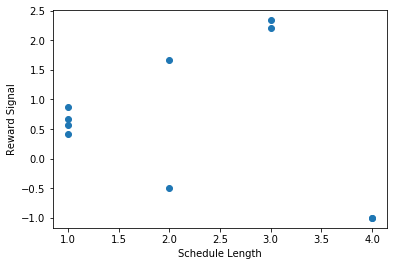

In [15]:
plt.plot(schedule_lens, rewards, "o")
plt.xlabel("Schedule Length")
plt.ylabel("Reward Signal")
plt.show()

#### Plot Remaining Times vs. Reward
* When remaining time is under 6-8, the reward should reapidly decrease,since karoshi happens due to lack of sleep/ bonuses are not rewarded for being sleep-deprived.
* When remaining time is 24, meaning the schedule is empty, undercommitment is not penalized but also not rewarded, leaving the agent with a reward of 0.
* The sweet spot is to have around 8-15 hours of remaining time, which accounts for sleep and free time. Having more free time than that makes the agent unlikely to be able to accrue schedule-fulfillment points.
* 

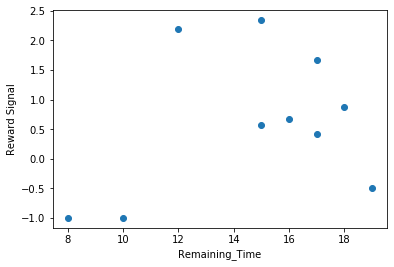

In [16]:
plt.plot(remaining_times, rewards, "o")
plt.xlabel("Remaining_Time")
plt.ylabel("Reward Signal")
plt.show()

______

## Implementing the Algorithms


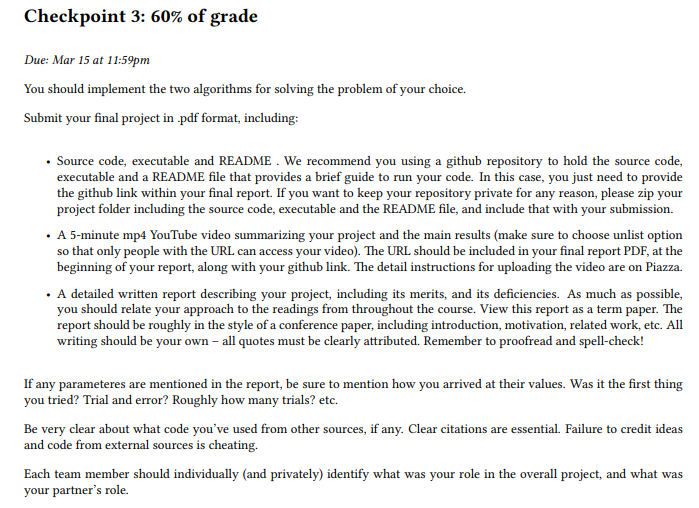

_________________

# Goal: Return an optimized schedule policy
* update policy or q_values 
* use policy or q_values to generate an optimized schedule
* use the optimal schedule length > restrict schedules to that length and then rework the same problem but using less states
* 3D graph of v_star, remaining_time, schedule_length 

Expected: optimal state should be [8-10, 3-5, 'any topic but ones with most relationships']
* so far, when I only return the remaining time and the length of the schedule, with the amount of states (complicated by the topic), it's not learning anything > not enough good signals in the environment 
* 

___________
## Algorithm 1: On-Policy First-Visit Monte Carlo Control

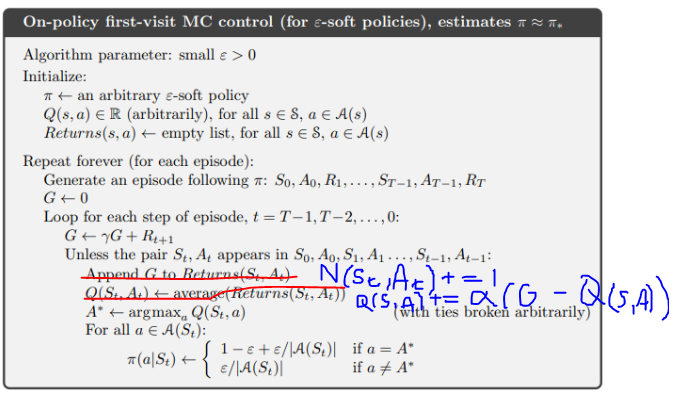

In [17]:
def init_q_values(init):
    if init == "zeros":
        q_values = np.zeros((len(pos_states), len(possible_actions)))  
    elif init == 'arb':
        q_values = np.ones((len(pos_states), len(possible_actions)))
        for indx, value in enumerate(q_values):
            q_values[indx] = np.random.rand()
    else: 
        q_values = np.ones((len(pos_states), len(possible_actions))) * init
    return q_values

In [18]:
def MonteCarlo(init, num_runs):
    # num of times that action a has been selected from state s
    N = np.zeros((len(pos_states), len(possible_actions)))
    N_0 = 1

    # hyperparameters
    gamma = 0.5    # discount factor - balance between being too myopic (0) and too farsighted (1)
    epsilon = N_0/(N_0 + 0) 

    # initialize policy, q_values, returns

    q_values = init_q_values(init)
    returns = np.zeros((len(pos_states), len(possible_actions)))
    policy = np.ones((len(pos_states), len(possible_actions))) * (epsilon/len(possible_actions)) 

    all_episodes = []
    all_episode_rewards = []

    for run in tqdm((range(num_runs)), position=0):

        remaining_time = 24
        schedule = {}
        topic = np.random.choice(possible_topics)

        state      = [remaining_time, len(schedule)]                   
        state_indx = pos_states.index(state)

        action = np.random.choice(possible_actions, p= policy[state_indx])

        episode = []
        episode_rewards = []

        while True:        
            if action != 7:
                new_state, reward, schedule, topic = step(remaining_time, schedule, topic, action)
            elif action == 7:
                new_state, reward, schedule, remaining_time = step(remaining_time, schedule, topic, action)
            
            ep = [state, action, reward, schedule]
            episode.append(ep)
            episode_rewards.append(reward)

            if new_state == 0:
                break

            remaining_time, len_schedule = new_state
            state = [remaining_time, len_schedule]
            state_indx = pos_states.index(state)

            action = np.random.choice(possible_actions, p= policy[state_indx])     
            action_indx = possible_actions.index(action)

        all_episodes.append(episode)
        all_episode_rewards.append(episode_rewards)

        G = 0
        #loop through episode in reverse
        for indx_rev, state_action in enumerate(episode[::-1]):
            state, action, reward, schedule = state_action
            state_indx = pos_states.index(state)
            action_indx = possible_actions.index(action)

            indx_state_action = len(episode_rewards) - indx_rev -1 

            G += gamma*G + episode_rewards[indx_state_action]
            returns[state_indx][action_indx] = G


            if state_action not in episode[:indx_state_action]:
                N[state_indx][action_indx] += 1
                alpha = 1/(N[state_indx][action_indx]) # use time-varying alpha  
                q_values[state_indx][action_indx] +=  alpha * (G - q_values[state_indx][action_indx])
                epsilon = N_0/(N_0 + np.min(N[state_indx][action_indx]))  # epsilon-greedy exploration strategy 

                #update policy
                optimal_action = np.argmax(q_values[state_indx])
                for action_indx in range(len(possible_actions)):
                    if action_indx == optimal_action:
                        policy[state_indx][action_indx] = 1 - epsilon + (epsilon/ len(possible_actions))
                    elif action_indx != optimal_action:
                        policy[state_indx][action_indx] = (epsilon/ len(possible_actions))

    return policy, q_values, all_episodes, all_episode_rewards

In [19]:
def quick_check(q_values, policy):
    #quick check of Q-values vs. policy
    
    print("<<QUICK CHECKS>>")
    oops = [100, 150, 200, 250]
    
    for oop in oops:
        print("----------------------")
        print("state:", pos_states[oop], "\nQs:", q_values[oop],"\nPi:", policy[oop])
        print("Q says", np.argmax(q_values[oop]), "| Pi says", np.argmax(policy[oop]))
    
    agreements = 0
    for state_indx, state in enumerate(pos_states):
        if np.argmax(q_values[state_indx]) ==  np.argmax(policy[state_indx]):
            agreements += 1
    print("Policy aligns with Q-values:", agreements / len(pos_states) * 100, "%")                                 
                                                         
    sys.stdout.flush()   

In [20]:
def get_opt_actions(algo, policy_or_values):
    
    
    if algo == "MC":
        optimal_actions = []
        for state_indx, state in enumerate(pos_states):
            action_indx = np.argmax(policy_or_values[state_indx])
            if action_indx == 0:
                action = 0
                optimal_actions.append(action)
            elif action_indx == 1:
                action = 1
                optimal_actions.append(action)
            elif action_indx == 2:
                action = 3
                optimal_actions.append(action)
            elif action_indx == 3:
                action = 5
                optimal_actions.append(action)
            elif action_indx == 4:
                action = 7
                optimal_actions.append(action)
            
            
    elif algo == "TD":
        optimal_actions = []
        for state_indx, state in enumerate(pos_states):
            action_indx = np.argmax(policy_or_values)
            if action_indx == 0:
                action = 0
                optimal_actions.append(action)
            elif action_indx == 1:
                action = 1
                optimal_actions.append(action)
            elif action_indx == 2:
                action = 3
                optimal_actions.append(action)
            elif action_indx == 3:
                action = 5
                optimal_actions.append(action)
            elif action_indx == 4:
                action = 7
                optimal_actions.append(action)
            
    return optimal_actions

In [21]:
def calc_V_star(q_values):
    #calculate optimal value function V_star
    V_star = []
    for state_indx in range(len(pos_states)):
        optimal_value = np.max(q_values[state_indx])
        V_star.append(optimal_value)
    len(V_star)
    V_star = np.array(V_star)
    
    return V_star

In [22]:
def plot_values_actions_states(algo, values_or_qvalues):
    if algo == "MC":
        V_star = calc_V_star(values_or_qvalues)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        ax[0].plot(np.argmax(values_or_qvalues, axis=0),["0","1","3","5","commit"], "-o")
        ax[0].set_xlabel("State Index (Remaining Hours Increase with State Index)")
        ax[0].set_ylabel("Optimal Action")
        ax[0].set_title("Optimal Action Trends per State Index")

        ax[1].plot(V_star, '-o')
        ax[1].set_ylabel("Values")
        ax[1].set_xlabel("State Index (Remaining Hours Increase with State Index)")
        ax[1].set_title("Values vs. State Index")

    elif algo == "TD":
        plt.plot(values_or_qvalues, '-o')
        plt.ylabel("Values")
        plt.xlabel("State Index (Remaining Hours Increase with State Index)")
        plt.title("Values vs. State Index")
        
    plt.show()

In [23]:
def plot_heatmap(V_star):
    
    x = np.linspace(0, 24, 25) #remaining times
    y = np.linspace(0, 10, len(possible_topics)) #possible schedule lengths
    X, Y = np.meshgrid(x, y)
    Z = np.ones((25, len(possible_topics)))

    for state_indx, state in enumerate(pos_states[1:]):
        r_time, len_schd = state
        value = V_star[state_indx]
        Z[r_time - 1][len_schd - 1] = value
        
    fig = plt.figure(figsize =(14, 9))
    ax = sns.heatmap(Z, linewidth=0.5, annot=True)
    plt.xlabel("Schedule Length (# topics before orgs/lab)")
    plt.ylabel("Remaining Time (hrs)")
    plt.title("Max Value per State")

    plt.xlim(0,)
    plt.ylim(0,24)
    plt.show()

    # x.shape,y.shape, Z.shape

In [24]:
def get_opt_schedules(V_star, all_episodes, optimal_actions):
    optimal_schedules = []
    part_optimal_schedules =  []
    
    optimal_schd_rewards = []
    part_opt_schd_rewards = []
    
    for state_indx, action in enumerate(optimal_actions):
        if action == 7:

            for episode in all_episodes:
                state, action, reward, schedule = episode[-1]
                
                if len(schedule) > 2 and "LabStuff" in schedule:
                    if state == pos_states[np.argmax(V_star)]:
                        optimal_schedules.append(schedule)
                        optimal_schd_rewards.append(reward)
    
                    elif state[0] == pos_states[np.argmax(V_star)][0] or state[1] == pos_states[np.argmax(V_star)][1]:
                        part_optimal_schedules.append(schedule)
                        part_opt_schd_rewards.append(reward)

    return optimal_schedules, part_optimal_schedules, optimal_schd_rewards, part_opt_schd_rewards

###  Run Monte Carlo using different Initializations

INIT Q-VALUES AS -0.1:  



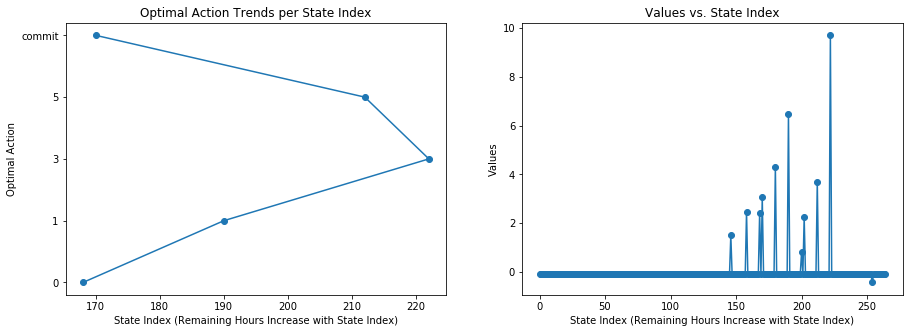

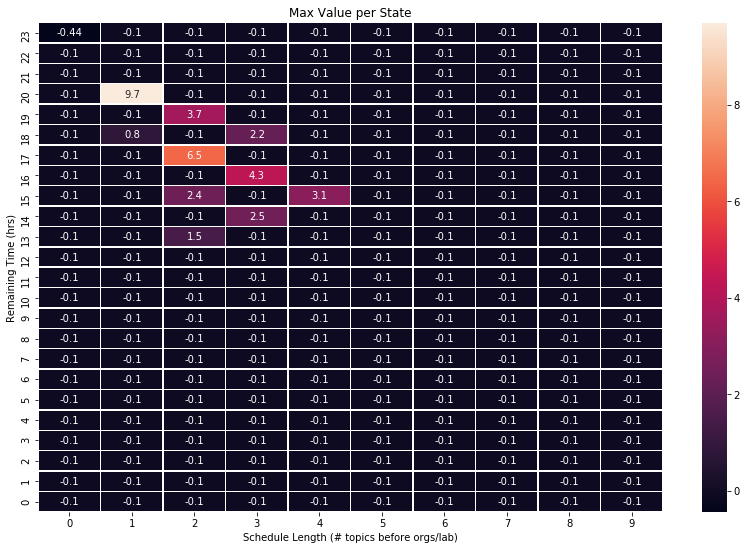

PRIOR TO ORGS/LABSTUFF:
Optimal Remaining Time: 21 HOURS 
Optimal Schedule Length: 1 COMMITMENTS

WITH ORGS/LABS IN FINAL CONSIDERATION
Optimal Schedules:
Partially Optimal Schedules:
---------------------------------------

INIT Q-VALUES AS 0.1:  



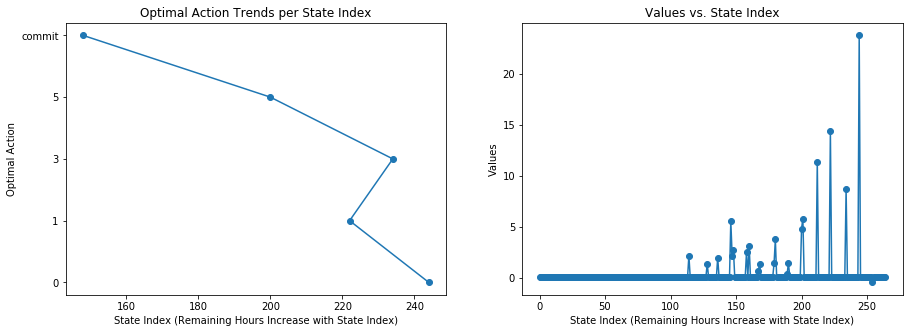

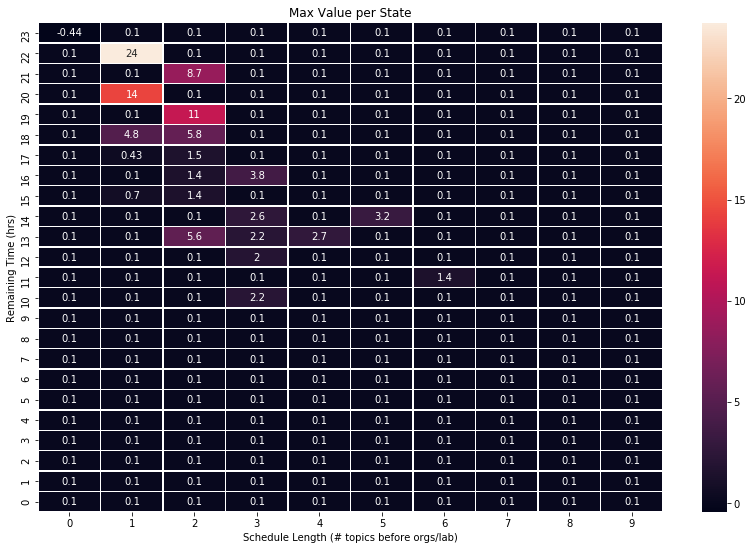

PRIOR TO ORGS/LABSTUFF:
Optimal Remaining Time: 23 HOURS 
Optimal Schedule Length: 1 COMMITMENTS

WITH ORGS/LABS IN FINAL CONSIDERATION
Optimal Schedules:
{'Orgs': 2, 'video-editing': 1, 'LabStuff': 1} | Fulfillment: 0.9
{'Orgs': 3, 'topology': 1, 'LabStuff': 2} | Fulfillment: -0.5
{'Orgs': 2, 'Japanese': 1, 'LabStuff': 2} | Fulfillment: -0.5
---------------------------------------

INIT Q-VALUES AS zeros:  



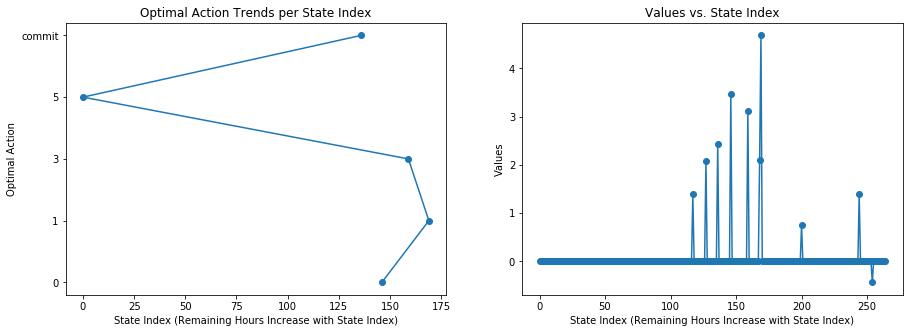

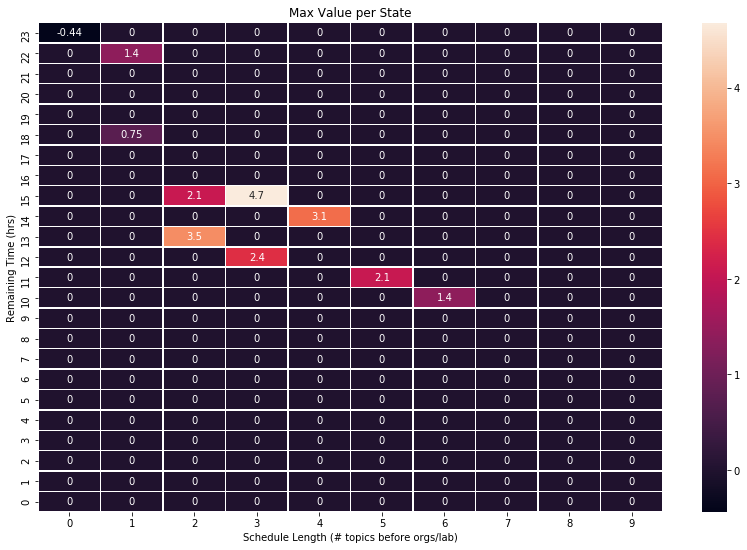

PRIOR TO ORGS/LABSTUFF:
Optimal Remaining Time: 16 HOURS 
Optimal Schedule Length: 3 COMMITMENTS

WITH ORGS/LABS IN FINAL CONSIDERATION
Optimal Schedules:
Partially Optimal Schedules:
{'front-end coding': 1, 'LabStuff': 2, 'topology': 5, 'Orgs': 2, 'psych/linguistics': 5} | Fulfillment: 2.44125
{'Orgs': 2, 'LabStuff': 1, 'front-end coding': 5, 'video-editing': 3} | Fulfillment: 1.4
---------------------------------------

INIT Q-VALUES AS arb:  



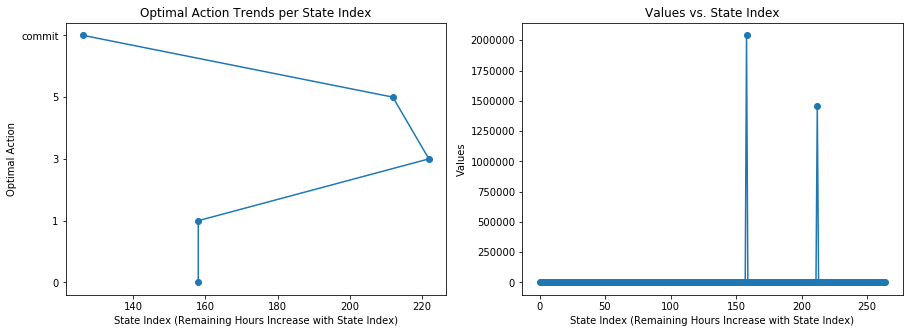

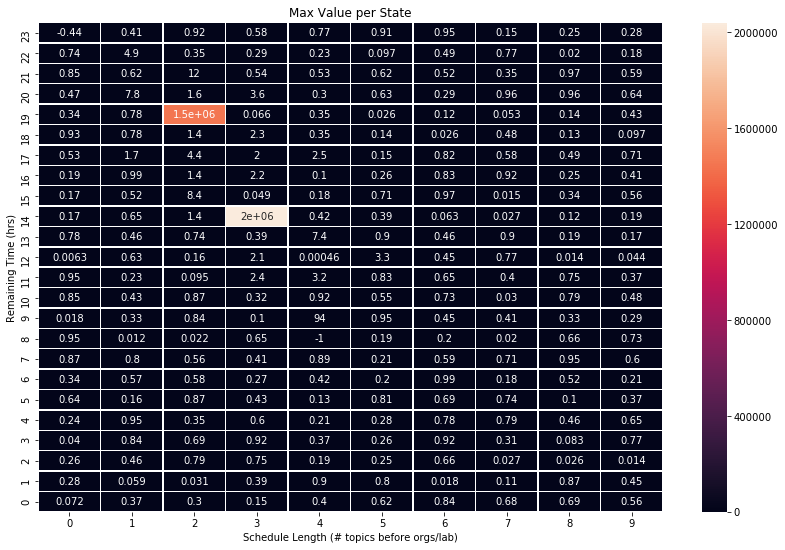

PRIOR TO ORGS/LABSTUFF:
Optimal Remaining Time: 15 HOURS 
Optimal Schedule Length: 3 COMMITMENTS

WITH ORGS/LABS IN FINAL CONSIDERATION
Optimal Schedules:
{'LabStuff': 2, 'graphic design': 3, 'Orgs': 1, 'Japanese': 5, 'animation': 1} | Fulfillment: 2.33625
{'topology': 5, 'graphic design': 1, 'Orgs': 2, 'Japanese': 3, 'LabStuff': 1} | Fulfillment: 2.15
{'LabStuff': 2, 'front-end coding': 5, 'video-editing': 1, 'webtooning': 3, 'Orgs': 4} | Fulfillment: 2.0156250000000004
{'front-end coding': 1, 'topology': 5, 'LabStuff': 1, 'physics': 3, 'Orgs': 4} | Fulfillment: 2.30625
{'video-editing': 5, 'Japanese': 1, 'R/statistical packages': 3, 'Orgs': 3, 'LabStuff': 1} | Fulfillment: 2.75
---------------------------------------

CPU times: user 2min 5s, sys: 6.42 s, total: 2min 11s
Wall time: 2min 5s


In [25]:
%%time 

num_runs = 100000
#try with different initialization of q_values
inits = [-0.1, 0.1,'zeros', 'arb']

policies = []
MC_init_qs = []
MC_init_eps = []
MC_init_ep_rewards = []
MC_init_opt_actions = []


for init in inits:
    print("\033[1;31mINIT Q-VALUES AS {}:  \033[0m\n".format(init))
    
    policy, q_values, all_episodes, all_episode_rewards = MonteCarlo(init, num_runs)
    optimal_actions = get_opt_actions("MC", policy)
    
    policies.append(policies)
    MC_init_qs.append(q_values)
    MC_init_eps.append(all_episodes)
    MC_init_ep_rewards.append(all_episode_rewards)
    MC_init_opt_actions.append(optimal_actions)
    print()
    
#     quick_check(q_values,policy)
#     print()
#     for action in possible_actions:
#         if action != 7:
#             print("optimal to allot",action, "hrs:", optimal_actions.count(action), "x")
#         else:
#             print("Optimal to commit:     ", optimal_actions.count(action), "x")
#     print()
    
    #calculate V_star & Plots
    V_star = calc_V_star(q_values)
    plot_values_actions_states("MC", q_values)
    plot_heatmap(V_star)
    best_r_time, best_len = pos_states[np.argmax(V_star)]
    print("PRIOR TO ORGS/LABSTUFF:")
    print("Optimal Remaining Time: {} HOURS \nOptimal Schedule Length: {} COMMITMENTS".format(best_r_time, best_len))
    print()
    
    # returns schedules that are EITHER the optimal length or optimal, get unique entries
    optimal_schedules, part_optimal_schds, opt_schd_rewards, part_opt_rewards = get_opt_schedules(V_star, all_episodes, optimal_actions)
    optimal_schedules = [dict(entry) for entry in set(frozenset(schd.items()) for schd in optimal_schedules)]
    part_optimal_schds = [dict(entry) for entry in set(frozenset(schd.items()) for schd in part_optimal_schds)]
    
    print("WITH ORGS/LABS IN FINAL CONSIDERATION")
    print("Optimal Schedules:")
    for indx, schd in enumerate(optimal_schedules):
        
        print(schd, "| Fulfillment:", opt_schd_rewards[indx])
        
    
    if optimal_schedules == []:
        print("Partially Optimal Schedules:")
        for indx, schd in enumerate(part_optimal_schds):
            print(schd, "| Fulfillment:", part_opt_rewards[indx])
            
    
    print("---------------------------------------\n")
    sys.stdout.flush()

In [34]:
import pickle
with open('MC_results.pickle', 'wb') as mc_results:
    pickle.dump([policies,
                 MC_init_qs, 
                 MC_init_eps, 
                 MC_init_ep_rewards, 
                 MC_init_opt_actions], mc_results)

___________
# Algorithm 2: TD($\lambda$)

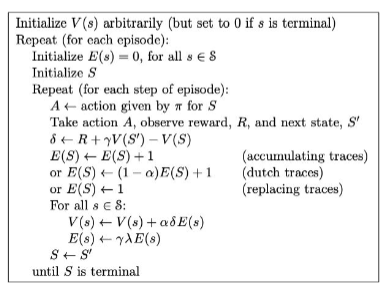

In [26]:
# epsilon-greedy policy 
def epsilon_greedy(epsilon, values, state):
    state_indx = pos_states.index(state)
    be_greedy = (np.random.random() > epsilon)
    if be_greedy:
        action = np.argmax(values[state_indx]) #optimal action
    else:
        action = np.random.choice(possible_actions) 
    return action

In [27]:
# # initialize V(s) 
def init_values(init):
    if init == "zeros":
        values = np.zeros((len(pos_states)))
    elif init == 'arb':
        values = np.ones((len(pos_states)))
        for state_indx,state in enumerate(pos_states):
            if state in terminal_states:
                values[state_indx] = 0
            else:
                values[state_indx] = np.random.random()
    else: 
        values = np.ones((len(pos_states))) * init
    return values

In [28]:
def TD(init, lmbda, num_eps):
    # initialize V(s) arbitrarily but set to 0 if state is terminal
    values = init_values(init)

    all_episodes = []
    all_episode_rewards = []

    for episode in tqdm(range(num_eps)):

        #initialize weights
        e_weights = np.zeros(len(pos_states))

        #initialize S
        remaining_time = 24
        schedule = {}
        topic = np.random.choice(possible_topics)

        state      = [remaining_time, len(schedule)]
        state_indx = pos_states.index(state)

        episode = []
        episode_rewards = []
        
        # for each step in episode
        while True:
            #take action, observe reward, new_state
            action = epsilon_greedy(epsilon, values, state) 
            action_indx = possible_actions.index(action)

            if action == 7:
                new_state, reward, schedule, remaining_time = step(remaining_time, schedule, topic, action)
                new_state_indx  = pos_states.index(new_state)
            elif action != 7:
                new_state, reward, schedule, topic = step(remaining_time, schedule, topic, action)
                new_state_indx  = pos_states.index(new_state)
                
            ep = [state, action, reward, schedule]
            episode.append(ep)
            episode_rewards.append(reward)

            # update error and weights
            td_error             = reward + gamma*values[new_state_indx] - values[state_indx]
            e_weights[state_indx]= (1 - alpha) * e_weights[state_indx]  + 1 #dutch traces

            #update values and eligibility weights for all states
            values               = values + alpha * td_error * e_weights
            e_weights            = gamma * lmbda * e_weights

            if new_state == 0:
                break

            remaining_time, len_schedule  = new_state
            state = [remaining_time, len_schedule]
            state_indx = pos_states.index(state) 
            
    
    all_episodes.append(episode)
    all_episode_rewards.append(episode_rewards)

    return values, all_episodes, all_episode_rewards

  INIT VALUES as 0.1 
  LAMBDA = 0 


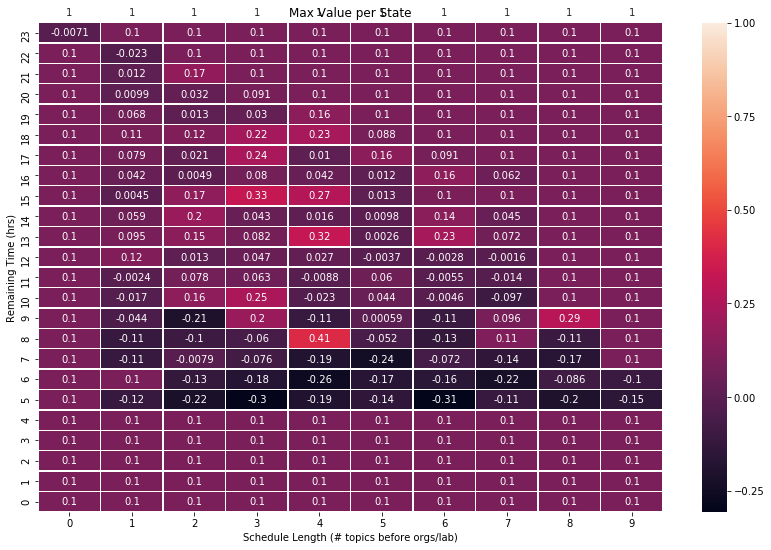

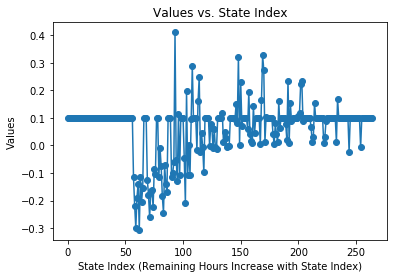

PRIOR TO ORGS/LAB:
Optimal Free Time: 9 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.5 


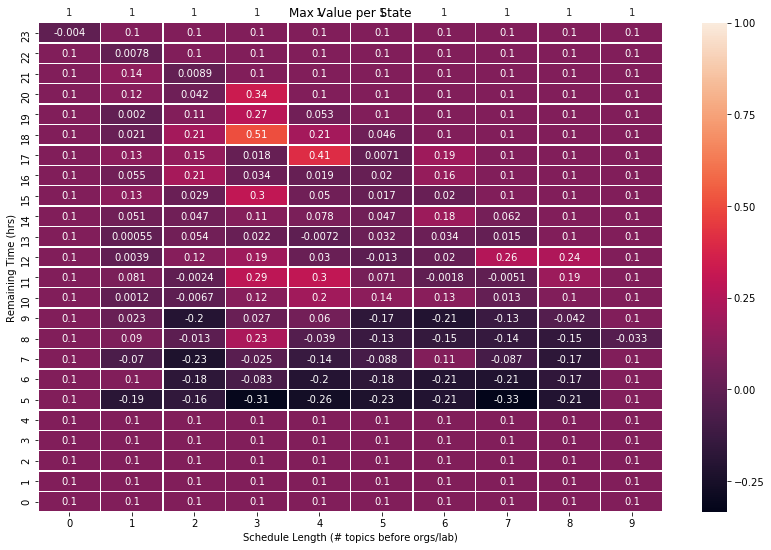

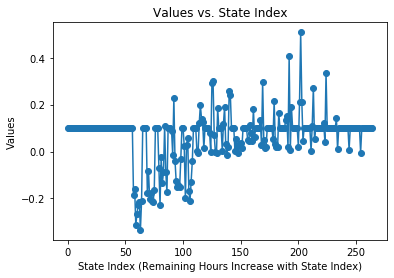

PRIOR TO ORGS/LAB:
Optimal Free Time: 19 HOURS 
Optimal Schedule Length (without Orgs/Lab): 3 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.75 


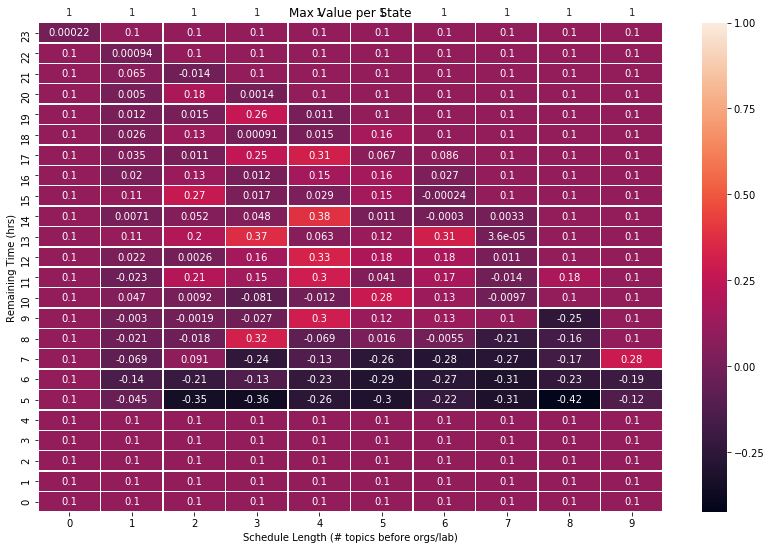

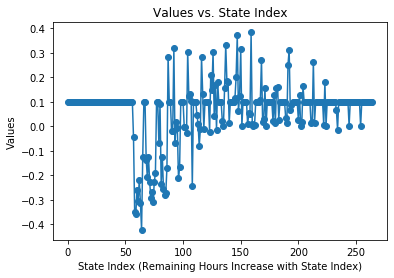

PRIOR TO ORGS/LAB:
Optimal Free Time: 15 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 1 


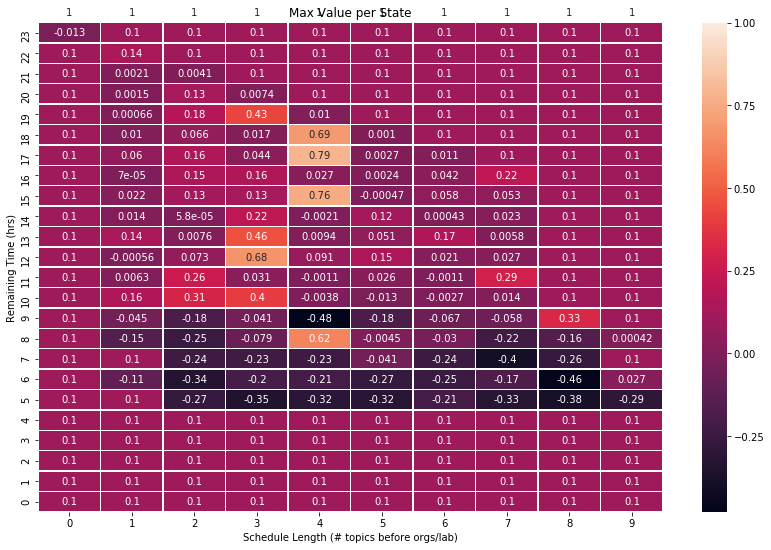

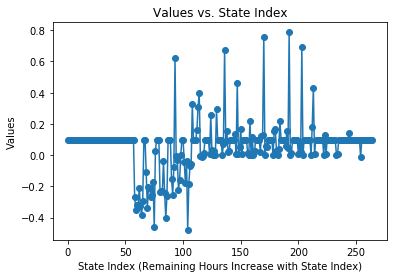

PRIOR TO ORGS/LAB:
Optimal Free Time: 18 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  INIT VALUES as arb 
  LAMBDA = 0 


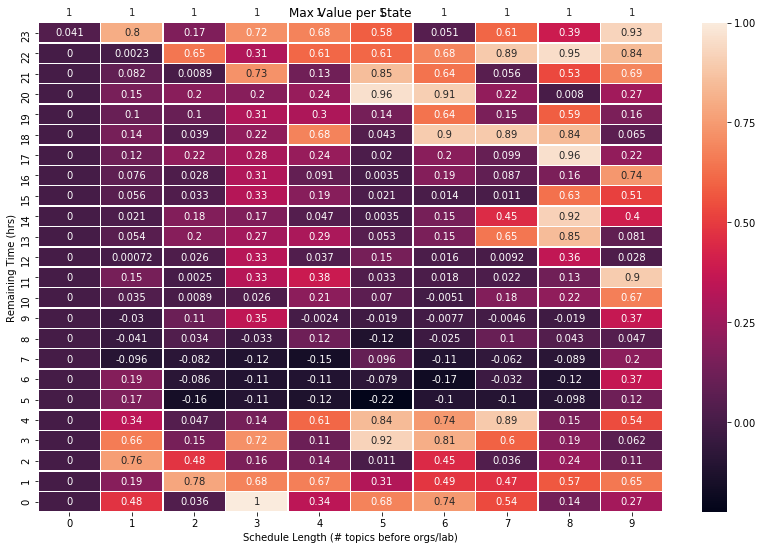

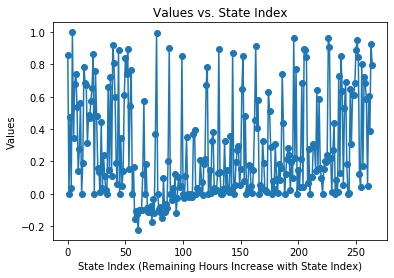

PRIOR TO ORGS/LAB:
Optimal Free Time: 1 HOURS 
Optimal Schedule Length (without Orgs/Lab): 3 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.5 


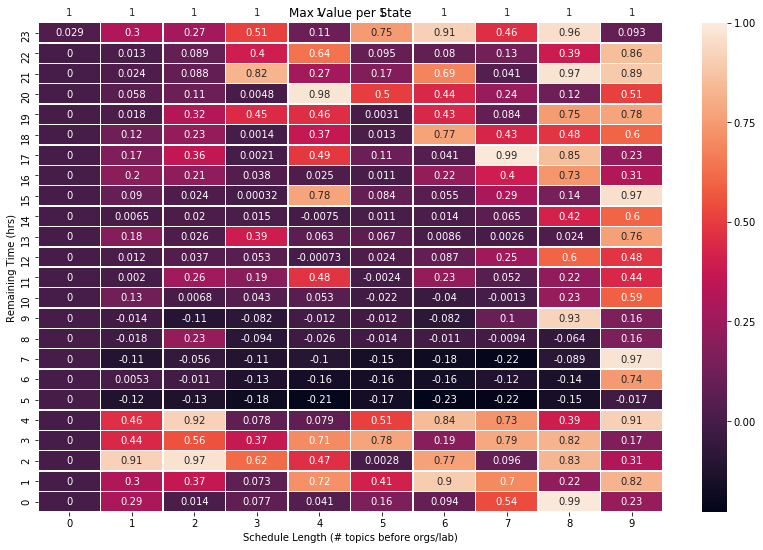

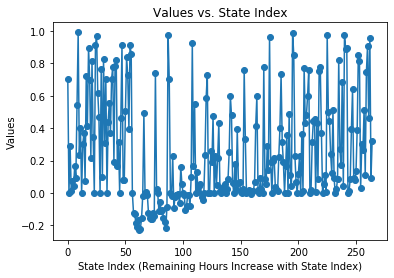

PRIOR TO ORGS/LAB:
Optimal Free Time: 1 HOURS 
Optimal Schedule Length (without Orgs/Lab): 8 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.75 


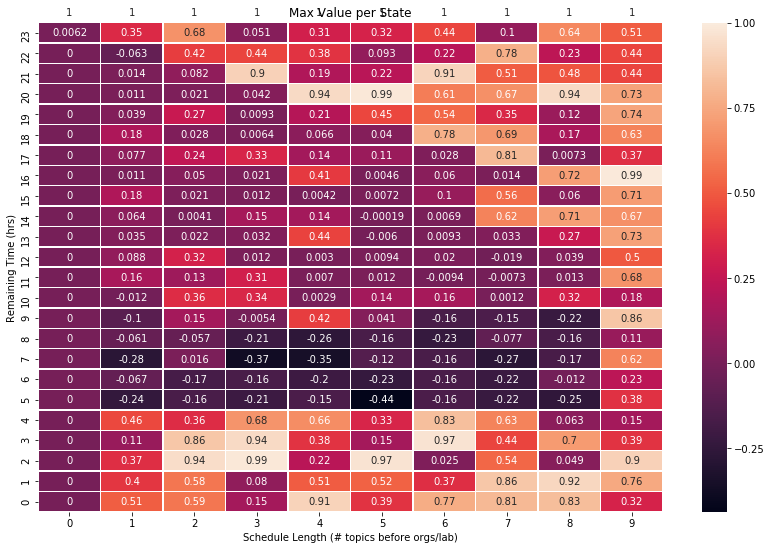

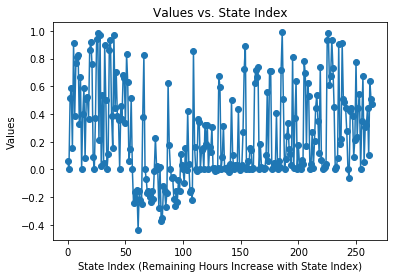

PRIOR TO ORGS/LAB:
Optimal Free Time: 17 HOURS 
Optimal Schedule Length (without Orgs/Lab): 9 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 1 


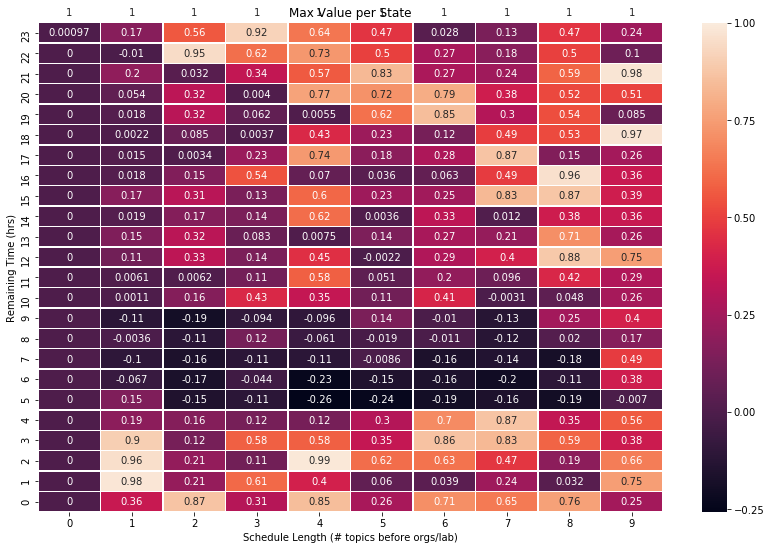

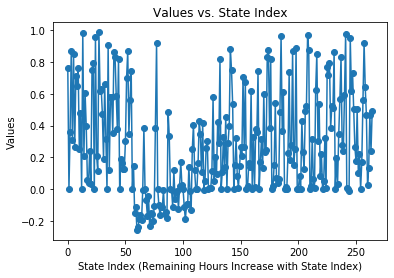

PRIOR TO ORGS/LAB:
Optimal Free Time: 3 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  INIT VALUES as zeros 
  LAMBDA = 0 


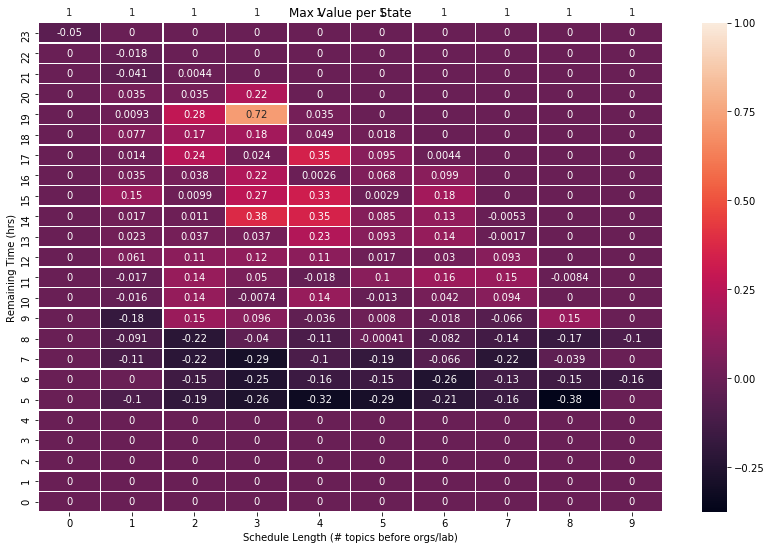

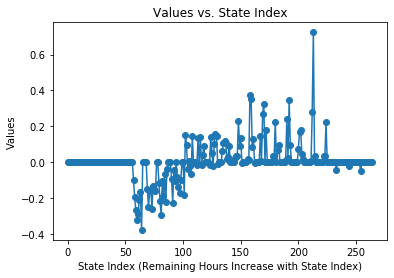

PRIOR TO ORGS/LAB:
Optimal Free Time: 20 HOURS 
Optimal Schedule Length (without Orgs/Lab): 3 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.5 


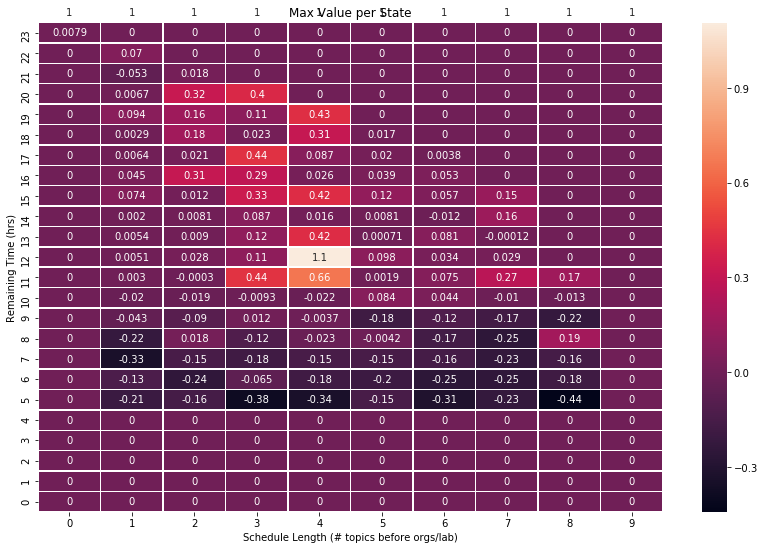

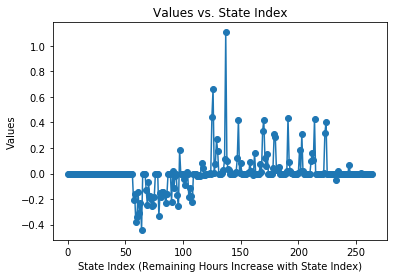

PRIOR TO ORGS/LAB:
Optimal Free Time: 13 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.75 


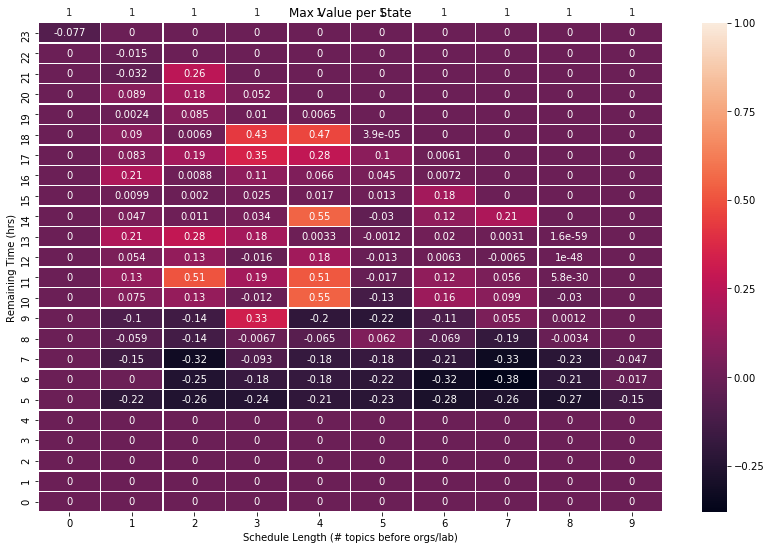

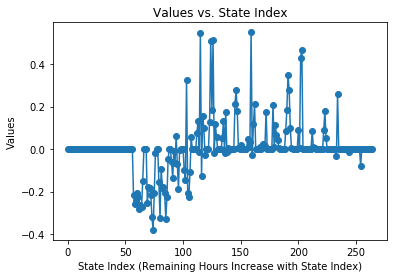

PRIOR TO ORGS/LAB:
Optimal Free Time: 15 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 1 


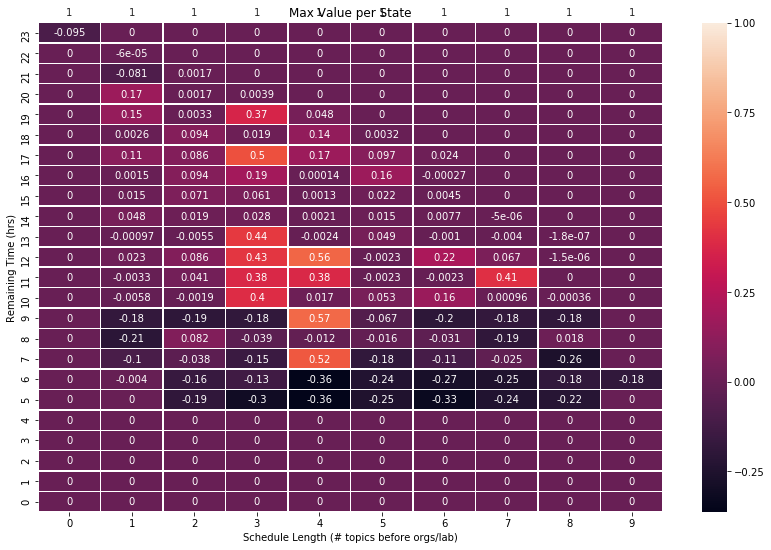

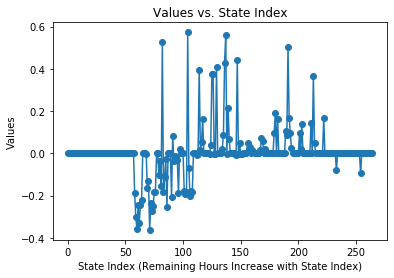

PRIOR TO ORGS/LAB:
Optimal Free Time: 10 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

CPU times: user 1h 43min 23s, sys: 1min 27s, total: 1h 44min 50s
Wall time: 1h 43min 8s


In [31]:
%%time 
gamma = 0.5 #1.0 
lmbdas = [0,0.5,0.75,1]
epsilon = 0.1
alpha = 0.1
init = 'arb'
inits = [0.1, 'arb', 'zeros']

num_eps = 100000 # number of runs/eps

TD_init_values = []
TD_init_eps = []
TD_init_ep_rewards = []
TD_init_opt_actions = []

for init in inits:
    print("\033[1;38m  INIT VALUES as {} \033[0m".format(init))
    for lmbda in lmbdas:
        print("\033[1;43m  LAMBDA = {} \033[0m".format(lmbda))

        values, all_episodes, all_episode_rewards = TD(init, lmbda, num_eps)
        optimal_actions = get_opt_actions("TD", values)
        
        TD_init_values.append(values)
        TD_init_eps.append(all_episodes)
        TD_init_ep_rewards.append(all_episode_rewards)
        TD_init_opt_actions.append(optimal_actions)
        
        #plot stuff
        plot_heatmap(values)
        plot_values_actions_states("TD", values)
        if np.argmax(values) != 0:
            best_r_time, best_len = pos_states[np.argmax(values)]
            print("PRIOR TO ORGS/LAB:")
            print("Optimal Free Time: {} HOURS \nOptimal Schedule Length (without Orgs/Lab): {} COMMITMENTS".format(best_r_time, best_len))


        # returns schedules that are EITHER the optimal length or optimal, get unique entries
        optimal_schedules, part_optimal_schds, opt_schd_rewards, part_opt_rewards = get_opt_schedules(values, all_episodes, optimal_actions)
        optimal_schedules = [dict(entry) for entry in set(frozenset(schd.items()) for schd in optimal_schedules)]
        part_optimal_schds = [dict(entry) for entry in set(frozenset(schd.items()) for schd in part_optimal_schds)]

        print("FACTORING IN ORGS/LAB:")
        print("Optimal Schedules:")
        for indx, schd in enumerate(optimal_schedules):
            print(schd, "| Fulfillment:", opt_schd_rewards[indx])
        
        print()
        if optimal_schedules == []:
            print("Partially Optimal Schedules:")
            for indx, schd in enumerate(part_optimal_schds):
                print(schd, "| Fulfillment:", part_opt_rewards[indx])
        print("---------------------------------------\n")
        sys.stdout.flush()

In [51]:
## Save Variables

In [36]:
with open('TD_results.pickle', 'wb') as td_results:
    pickle.dump([TD_init_values, 
                 TD_init_eps, 
                 TD_init_ep_rewards, 
                 TD_init_opt_actions], td_results)

with open('functions.pickle', 'wb') as functions:
    pickle.dump([quick_check, 
                get_opt_actions, 
                calc_V_star, 
                plot_values_actions_states, 
                plot_heatmap, 
                get_opt_schedules], functions)

In [55]:
with open('TD_results.pickle', 'rb') as td_results:
    resultsTD = pickle.load(td_results)
    
with open('MC_results.pickle', 'rb') as mc_results:
    resultsMC = pickle.load(mc_results)
    
with open('functions.pickle', 'rb') as functions:
    funx = pickle.load(functions)